# Computer Vision: scikit-image + scikit-learn

![](python-logo.png)
![](logo.png)
![](scikit-learn-logo-small.png)

# Problema: 
## Classificar Imagens da Retina
#### *Com Retinopatia* 

#### *Sem Retinopatia*


In [1]:
import numpy as np
from numpy import copy
import matplotlib.pyplot as plt
from skimage.io import imread_collection,imsave
from sklearn.model_selection import train_test_split
from glob import glob
from scipy.stats import randint as sp_randint
import time
from skimage.color import rgb2grey
from skimage.filters import threshold_otsu
from skimage.measure import label,regionprops
import copy
from scipy.stats.mstats_basic import skew, kurtosis
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")


#%matplotlib inline

#%matplotlib widget
#%matplotlib notebook
%matplotlib inline


# Read images from database

In [2]:
path = "RIMONE-db-r2/"

In [3]:
benigno = glob(path+'benigno/*.jpg')

In [4]:
print('A base de imagens da retina possui {} exemplos benignos.'.format(len(benigno)))

A base de imagens da retina possui 255 exemplos benignos.


In [5]:
maligno = glob(path+'maligno/*.jpg')

In [6]:
print('A base de imagens da retina possui {} exemplos malignos.'.format(len(maligno)))

A base de imagens da retina possui 200 exemplos malignos.


In [7]:
images = imread_collection(benigno+maligno)

Text(0.5, 1.0, 'Exemplo de imagem da base')

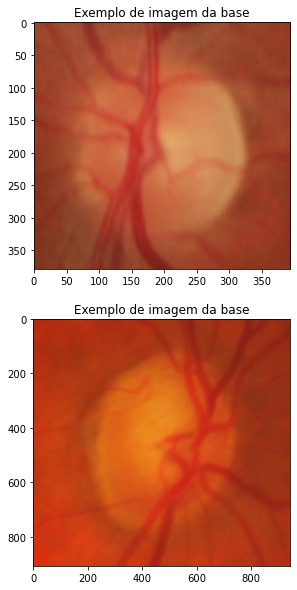

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(images[0])
ax[0].set_title('Exemplo de imagem da base')
ax[1].imshow(images[350])
ax[1].set_title('Exemplo de imagem da base')

In [9]:
labels = np.concatenate((np.zeros(len(benigno)),np.ones(len(maligno))))
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Extracting Features using GLCM

In [10]:
from skimage.feature import greycomatrix,greycoprops

### Parameter

- Distance
- Angle

In [11]:
d = 2

In [12]:
features = np.zeros((len(labels),18)) #6 features x 3 color channels
start = time.time()

for id_im,imagem in enumerate(images):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
    for id_ch in range(3):
        matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
        matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
        matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
        matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4 
        props = np.zeros((6))
        props[0] = greycoprops(matrix,'contrast')
        props[1] = greycoprops(matrix,'dissimilarity')
        props[2] = greycoprops(matrix,'homogeneity')
        props[3] = greycoprops(matrix,'energy')
        props[4] = greycoprops(matrix,'correlation')
        props[5] = greycoprops(matrix,'ASM')
        features[id_im,id_ch*6:(id_ch+1)*6] = props

end = time.time()
print('time = ', end - start)

Extraindo atributos: 455 imagens processadas de 455.
time =  27.121124029159546


# Visualizando os atributos

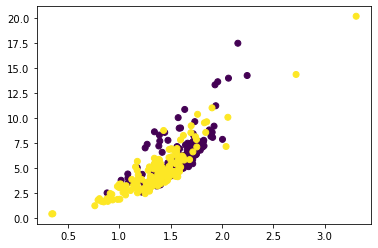

In [13]:
plt.scatter(features[:,1],features[:,6],c=labels)

In [14]:
pca = PCA()
pca.fit(features)
transform = pca.transform(features)
print(np.sum(pca.explained_variance_ratio_[0:3]))

0.9973185322472015


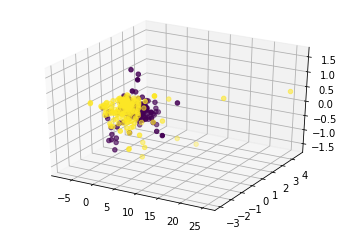

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[:,0],transform[:,1], transform[:,2],c=labels)

# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Split Data

In [16]:
train = 0.9
test = 1-train

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(transform, labels, test_size=test)

In [18]:
print('Quantidade treino = ', len(X_train))
print('Quantidade teste = ', len(X_test))

Quantidade treino =  409
Quantidade teste =  46


### Train/Test

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [20]:
c_rf = RandomForestClassifier()
c_rf.fit(X_train,y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest using all features: {}'.format(acc_rf))

Accuracy Random Forest using all features: 0.8695652173913043


In [21]:
n_components = 3
c_rf = RandomForestClassifier()
c_rf.fit(X_train_pca[:,0:n_components],y_train_pca)
pred_pca = c_rf.predict(X_test_pca[:,0:n_components])
acc_rf_pca = accuracy_score(y_test_pca, pred_pca)
print('Accuracy Random Forest unsing {} PCA components: {}'.format(n_components, acc_rf_pca))

Accuracy Random Forest unsing 3 PCA components: 0.7391304347826086


### Computing standard deviation

In [22]:
n = 100
acc_rf = []
c_rf = RandomForestClassifier()
for i in range(n):
    clear_output(wait=True)
    print('rodada {} de {}.'.format(i+1,n))

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)
    c_rf.fit(X_train,y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf),np.std(acc_rf)))

rodada 100 de 100.
Mean accuracy Random Forest: 0.8121739130434783+-0.05302922117735417


In [23]:
n = 100
n_components = 10
acc_rf_pca = []
c_rf = RandomForestClassifier()
for i in range(n):
    clear_output(wait=True)
    print('rodada {} de {}.'.format(i,n))
    
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(transform[:,0:n_components], labels, test_size=test)
    c_rf.fit(X_train_pca,y_train_pca)
    pred_pca = c_rf.predict(X_test_pca)
    acc_rf_pca.append(accuracy_score(y_test_pca, pred_pca))
print("Mean accuracy Random Forest using {} PCA components: {}+-{}".format(n_components, np.mean(acc_rf_pca),np.std(acc_rf_pca)))

rodada 99 de 100.
Mean accuracy Random Forest using 10 PCA components: 0.815+-0.04596116960577907
